In [1]:
# Data setup (Titanic Dataset)
import pandas as pd
import numpy as np

np.random.seed(42)
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(url)
print(df.shape)
print(df.head(3))

(891, 12)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  


# 📊 Multi-Level Grouping and Custom Aggregations in pandas

# 🔄 1. Basic Multi-Level Grouping
## Example 1: Two-Level Grouping with Basic Aggregations

In [2]:
# Group by Class, then Gender
multi_group = df.groupby(['Pclass', 'Sex']).agg({
    'Survived': ['count', 'sum', 'mean'],
    'Age': ['mean', 'median', 'std'],
    'Fare': ['mean', 'median', 'max']
}).round(3)

print("Two-Level Grouping (Class × Gender):")
print(multi_group)
print("\n" + "="*60)

Two-Level Grouping (Class × Gender):
              Survived                Age                    Fare          \
                 count sum   mean    mean median     std     mean  median   
Pclass Sex                                                                  
1      female       94  91  0.968  34.612   35.0  13.612  106.126  82.665   
       male        122  45  0.369  41.281   40.0  15.140   67.226  41.262   
2      female       76  70  0.921  28.723   28.0  12.873   21.970  22.000   
       male        108  17  0.157  30.741   30.0  14.794   19.742  13.000   
3      female      144  72  0.500  21.750   21.5  12.730   16.119  12.475   
       male        347  47  0.135  26.508   25.0  12.160   12.662   7.925   

                        
                   max  
Pclass Sex              
1      female  512.329  
       male    512.329  
2      female   65.000  
       male     73.500  
3      female   69.550  
       male     69.550  



# # Example 2: Three-Level Grouping

In [3]:
# Add Embarkation point as third level
three_level_group = df.groupby(['Pclass', 'Sex', 'Embarked']).agg({
    'Survived': ['count', 'mean'],
    'Fare': ['mean', 'std'],
    'Age': 'mean'
}).round(3)

print("Three-Level Grouping (Class × Gender × Embarkation):")
print(three_level_group.head(10))  # Show first 10 rows
print(f"\nTotal unique groups: {len(three_level_group)}")
print("="*60)

Three-Level Grouping (Class × Gender × Embarkation):
                       Survived            Fare              Age
                          count   mean     mean      std    mean
Pclass Sex    Embarked                                          
1      female C              43  0.977  115.640   88.572  36.053
              Q               1  1.000   90.000      NaN  33.000
              S              48  0.958   99.027   61.094  32.705
       male   C              42  0.405   93.537  108.760  40.111
              Q               1  0.000   90.000      NaN  44.000
              S              79  0.354   52.950   50.254  41.897
2      female C               7  1.000   25.268   12.876  19.143
              Q               2  1.000   12.350    0.000  30.000
              S              67  0.910   21.913   10.760  29.720
       male   C              10  0.200   25.421   10.876  25.938

Total unique groups: 18


# 🎯 2. Custom Aggregations with Multi-Level Grouping
## Example 3: Complex Custom Metrics

In [4]:
# Define custom aggregation functions
def survival_summary(series):
    """Return multiple survival statistics"""
    total = len(series)
    survived = series.sum()
    rate = survived / total if total > 0 else 0
    return pd.Series({
        'total': total,
        'survived': survived,
        'survival_rate': rate,
        'mortality_rate': 1 - rate,
        'survival_percentage': f"{rate*100:.1f}%"
    })

def fare_analysis(series):
    """Analyze fare distribution"""
    clean_series = series.dropna()
    if len(clean_series) == 0:
        return pd.Series({
            'avg_fare': 0,
            'fare_range': 0,
            'fare_std': 0,
            'fare_iqr': 0
        })
    
    q1 = clean_series.quantile(0.25)
    q3 = clean_series.quantile(0.75)
    
    return pd.Series({
        'avg_fare': clean_series.mean(),
        'fare_range': clean_series.max() - clean_series.min(),
        'fare_std': clean_series.std(),
        'fare_iqr': q3 - q1,
        'fare_q1': q1,
        'fare_q3': q3
    })

def age_demographics(series):
    """Age distribution analysis"""
    clean_age = series.dropna()
    if len(clean_age) == 0:
        return pd.Series({
            'avg_age': 0,
            'age_diversity': 0,
            'children_pct': 0,
            'seniors_pct': 0
        })
    
    children = (clean_age < 18).sum()
    seniors = (clean_age > 60).sum()
    
    return pd.Series({
        'avg_age': clean_age.mean(),
        'age_std': clean_age.std(),
        'age_diversity': clean_age.std() / clean_age.mean() if clean_age.mean() > 0 else 0,
        'children_pct': children / len(clean_age) * 100,
        'seniors_pct': seniors / len(clean_age) * 100,
        'young_adults_pct': ((clean_age >= 18) & (clean_age <= 30)).sum() / len(clean_age) * 100
    })

# Apply custom aggregations with multi-level grouping
custom_multi_agg = df.groupby(['Pclass', 'Sex']).apply(
    lambda group: pd.Series({
        'survival_stats': survival_summary(group['Survived']),
        'fare_stats': fare_analysis(group['Fare']),
        'age_stats': age_demographics(group['Age']),
        'family_avg': (group['SibSp'] + group['Parch']).mean(),
        'ticket_unique': group['Ticket'].nunique()
    })
).round(3)

print("Custom Aggregations with Multi-Level Grouping:")
print(custom_multi_agg.head())
print("\n" + "="*60)

Custom Aggregations with Multi-Level Grouping:
                                                  survival_stats  \
Pclass Sex                                                         
1      female  total                        94
survived      ...   
       male    total                       122
survived      ...   
2      female  total                        76
survived      ...   
       male    total                       108
survived      ...   
3      female  total                    144
survived         ...   

                                                      fare_stats  \
Pclass Sex                                                         
1      female  avg_fare      106.125798
fare_range    486.400...   
       male    avg_fare       67.226127
fare_range    512.329...   
2      female  avg_fare      21.970121
fare_range    54.50000...   
       male    avg_fare      19.741782
fare_range    73.50000...   
3      female  avg_fare      16.118810
fare_range    62.80000...   


C:\Users\touhi\AppData\Local\Temp\ipykernel_16944\2295644631.py:62: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  custom_multi_agg = df.groupby(['Pclass', 'Sex']).apply(


# Example 4: Clean Named Aggregations

In [5]:
# Using named aggregations for readability
named_multi_agg = df.groupby(['Pclass', 'Sex']).agg(
    passenger_count=('PassengerId', 'count'),
    survival_count=('Survived', 'sum'),
    survival_rate=('Survived', lambda x: f"{x.mean()*100:.1f}%"),
    avg_fare=('Fare', 'mean'),
    median_fare=('Fare', 'median'),
    fare_range=('Fare', lambda x: x.max() - x.min()),
    avg_age=('Age', 'mean'),
    age_iqr=('Age', lambda x: x.quantile(0.75) - x.quantile(0.25)),
    children_count=('Age', lambda x: (x < 18).sum()),
    family_size_avg=('SibSp', lambda s: s.mean() + df.loc[s.index, 'Parch'].mean() + 1)
).round(3)

print("Named Aggregations with Multi-Level Grouping:")
print(named_multi_agg)
print("\n" + "="*60)

Named Aggregations with Multi-Level Grouping:
               passenger_count  survival_count survival_rate  avg_fare  \
Pclass Sex                                                               
1      female               94              91         96.8%   106.126   
       male                122              45         36.9%    67.226   
2      female               76              70         92.1%    21.970   
       male                108              17         15.7%    19.742   
3      female              144              72         50.0%    16.119   
       male                347              47         13.5%    12.662   

               median_fare  fare_range  avg_age  age_iqr  children_count  \
Pclass Sex                                                                 
1      female       82.665     486.400   34.612   21.000               8   
       male         41.262     512.329   41.281   21.000               4   
2      female       22.000      54.500   28.723   13.750 

# 🔍 4. Advanced: Multi-Level Grouping with Transformation
## Example 5: Within-Group Normalization

In [6]:
# Calculate relative metrics within each group
df['fare_relative_to_group'] = df.groupby(['Pclass', 'Sex'])['Fare'].transform(
    lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
)

df['age_rank_in_group'] = df.groupby(['Pclass', 'Sex'])['Age'].transform(
    lambda x: x.rank(pct=True)
)

df['survival_diff_from_group_mean'] = df.groupby(['Pclass', 'Sex'])['Survived'].transform(
    lambda x: x - x.mean()
)

# Analyze the transformed data
transformed_analysis = df.groupby(['Pclass', 'Sex']).agg({
    'fare_relative_to_group': ['mean', 'std', 'min', 'max'],
    'age_rank_in_group': ['mean', 'std'],
    'survival_diff_from_group_mean': ['mean', 'sum']
}).round(3)

print("Analysis of Within-Group Normalized Metrics:")
print(transformed_analysis)
print("\n" + "="*60)

Analysis of Within-Group Normalized Metrics:
              fare_relative_to_group                    age_rank_in_group  \
                                mean  std    min    max              mean   
Pclass Sex                                                                  
1      female                    0.0  1.0 -1.080  5.470             0.506   
       male                      0.0  1.0 -0.867  5.740             0.505   
2      female                   -0.0  1.0 -1.053  3.951             0.507   
       male                     -0.0  1.0 -1.323  3.603             0.505   
3      female                   -0.0  1.0 -0.801  4.571             0.505   
       male                     -0.0  1.0 -1.084  4.870             0.502   

                     survival_diff_from_group_mean       
                 std                          mean  sum  
Pclass Sex                                               
1      female  0.290                          -0.0 -0.0  
       male    0.290         

# 🎪 5. Multi-Level Grouping with Binned/Categorical Variables
## Example 6: Grouping with Custom Categories

In [7]:
# Create custom categories
df['Age_Group'] = pd.cut(df['Age'], 
                         bins=[0, 12, 18, 30, 50, 100],
                         labels=['Child', 'Teen', 'Young Adult', 'Middle Aged', 'Senior'])

df['Fare_Category'] = pd.qcut(df['Fare'], 
                              q=4,
                              labels=['Cheap', 'Economy', 'Premium', 'Luxury'])

df['Family_Size'] = df['SibSp'] + df['Parch'] + 1
df['Family_Type'] = pd.cut(df['Family_Size'],
                          bins=[0, 1, 4, 11],
                          labels=['Alone', 'Small Family', 'Large Family'])

# Multi-level grouping with custom categories
category_multi_group = df.groupby(['Pclass', 'Age_Group', 'Family_Type']).agg({
    'Survived': ['count', 'mean'],
    'Fare': 'mean',
    'Sex': lambda x: (x == 'female').mean()  # % female in group
}).round(3)

print("Multi-Level Grouping with Custom Categories:")
print(category_multi_group.head(15))
print("\n" + "="*60)

C:\Users\touhi\AppData\Local\Temp\ipykernel_16944\2740542674.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_multi_group = df.groupby(['Pclass', 'Age_Group', 'Family_Type']).agg({


Multi-Level Grouping with Custom Categories:
                                Survived            Fare      Sex
                                   count   mean     mean <lambda>
Pclass Age_Group   Family_Type                                   
1      Child       Alone               0    NaN      NaN      NaN
                   Small Family        4  0.750  126.240    0.250
                   Large Family        0    NaN      NaN      NaN
       Teen        Alone               1  1.000   86.500    1.000
                   Small Family       10  0.900  112.158    0.800
                   Large Family        1  1.000  262.375    1.000
       Young Adult Alone              24  0.792   71.428    0.583
                   Small Family       17  0.588   91.438    0.412
                   Large Family        4  0.750  262.844    0.750
       Middle Aged Alone              40  0.600   77.654    0.350
                   Small Family       46  0.739   97.752    0.500
                   Large Family

# 📊 6. Aggregation with Multiple Output Levels
## Example 7: Hierarchical Aggregation Output

In [8]:
def comprehensive_group_analysis(group_df):
    """Return hierarchical analysis results"""
    results = {}
    
    # Level 1: Basic counts
    results['counts'] = {
        'total': len(group_df),
        'female': (group_df['Sex'] == 'female').sum(),
        'male': (group_df['Sex'] == 'male').sum()
    }
    
    # Level 2: Survival analysis
    survival_mask = group_df['Survived'] == 1
    results['survival'] = {
        'total_survived': survival_mask.sum(),
        'survival_rate': survival_mask.mean(),
        'female_survival_rate': group_df[group_df['Sex'] == 'female']['Survived'].mean(),
        'male_survival_rate': group_df[group_df['Sex'] == 'male']['Survived'].mean()
    }
    
    # Level 3: Economic analysis
    results['economic'] = {
        'avg_fare': group_df['Fare'].mean(),
        'median_fare': group_df['Fare'].median(),
        'fare_std': group_df['Fare'].std(),
        'total_fare_revenue': group_df['Fare'].sum()
    }
    
    # Level 4: Demographic analysis
    results['demographic'] = {
        'avg_age': group_df['Age'].mean(),
        'children_count': (group_df['Age'] < 18).sum(),
        'family_size_avg': group_df['Family_Size'].mean()
    }
    
    # Convert to flattened structure
    flattened = {}
    for category, metrics in results.items():
        for metric_name, value in metrics.items():
            flattened[f"{category}_{metric_name}"] = value
    
    return pd.Series(flattened)

# Apply hierarchical analysis
hierarchical_analysis = df.groupby(['Pclass', 'Embarked']).apply(
    comprehensive_group_analysis
).round(3)

print("Hierarchical Multi-Level Group Analysis:")
print(hierarchical_analysis)
print("\n" + "="*60)

Hierarchical Multi-Level Group Analysis:
                 counts_total  counts_female  counts_male  \
Pclass Embarked                                             
1      C                 85.0           43.0         42.0   
       Q                  2.0            1.0          1.0   
       S                127.0           48.0         79.0   
2      C                 17.0            7.0         10.0   
       Q                  3.0            2.0          1.0   
       S                164.0           67.0         97.0   
3      C                 66.0           23.0         43.0   
       Q                 72.0           33.0         39.0   
       S                353.0           88.0        265.0   

                 survival_total_survived  survival_survival_rate  \
Pclass Embarked                                                    
1      C                            59.0                   0.694   
       Q                             1.0                   0.500   
       S       

C:\Users\touhi\AppData\Local\Temp\ipykernel_16944\592398755.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hierarchical_analysis = df.groupby(['Pclass', 'Embarked']).apply(


# 🔄 7. Multi-Level Grouping with Filtering
## Example 8: Conditional Aggregations

In [9]:
# Define conditional aggregation functions
def conditional_metrics(group_df):
    """Calculate metrics based on conditions"""
    metrics = {}
    
    # Only for survivors
    survivors = group_df[group_df['Survived'] == 1]
    if len(survivors) > 0:
        metrics['survivor_avg_fare'] = survivors['Fare'].mean()
        metrics['survivor_avg_age'] = survivors['Age'].mean()
        metrics['survivor_female_pct'] = (survivors['Sex'] == 'female').mean()
    
    # Only for children
    children = group_df[group_df['Age'] < 18]
    if len(children) > 0:
        metrics['child_survival_rate'] = children['Survived'].mean()
        metrics['child_count'] = len(children)
    
    # By fare category
    if len(group_df) > 0:
        fare_quartiles = group_df['Fare'].quantile([0.25, 0.5, 0.75])
        metrics['fare_q1'] = fare_quartiles.iloc[0]
        metrics['fare_median'] = fare_quartiles.iloc[1]
        metrics['fare_q3'] = fare_quartiles.iloc[2]
        
        # High fare passengers (> 75th percentile)
        high_fare = group_df[group_df['Fare'] > metrics['fare_q3']]
        if len(high_fare) > 0:
            metrics['high_fare_survival_rate'] = high_fare['Survived'].mean()
    
    return pd.Series(metrics)

# Apply conditional aggregations
conditional_analysis = df.groupby(['Pclass', 'Sex']).apply(conditional_metrics).round(3)

print("Conditional Aggregations with Multi-Level Grouping:")
print(conditional_analysis)
print("\n" + "="*60)

Conditional Aggregations with Multi-Level Grouping:
               survivor_avg_fare  survivor_avg_age  survivor_female_pct  \
Pclass Sex                                                                
1      female            105.978            34.939                  1.0   
       male               74.637            36.248                  0.0   
2      female             22.289            28.081                  1.0   
       male               21.095            16.022                  0.0   
3      female             12.465            19.330                  1.0   
       male               15.580            22.274                  0.0   

               child_survival_rate  child_count  fare_q1  fare_median  \
Pclass Sex                                                              
1      female                0.875          8.0   57.245       82.665   
       male                  1.000          4.0   27.728       41.262   
2      female                1.000         12.0   13.00

C:\Users\touhi\AppData\Local\Temp\ipykernel_16944\3730226236.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  conditional_analysis = df.groupby(['Pclass', 'Sex']).apply(conditional_metrics).round(3)


# 📊 8. Visualization of Multi-Level Grouped Data

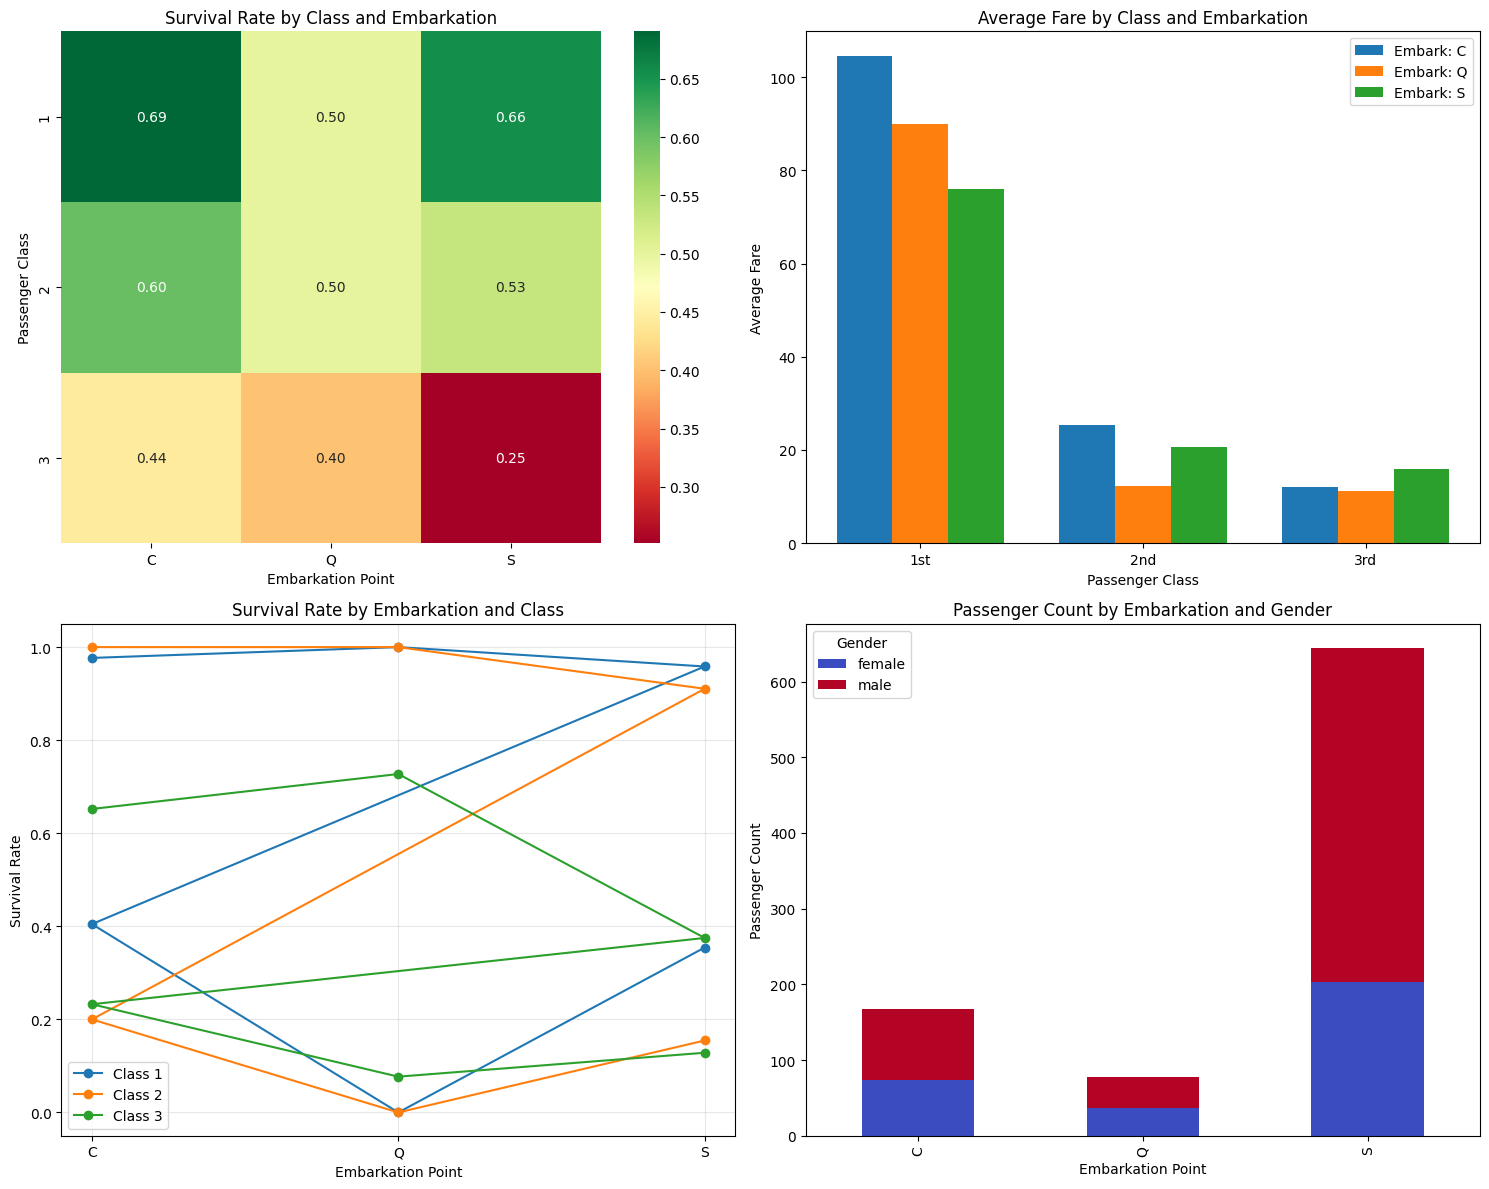

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for visualization
viz_data = df.groupby(['Pclass', 'Sex', 'Embarked']).agg({
    'Survived': 'mean',
    'Fare': 'mean',
    'Age': 'mean'
}).reset_index()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Heatmap of survival rates by class and embarkation
heatmap_data = viz_data.pivot_table(
    index='Pclass', columns='Embarked', values='Survived'
)
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn', ax=axes[0, 0])
axes[0, 0].set_title('Survival Rate by Class and Embarkation')
axes[0, 0].set_xlabel('Embarkation Point')
axes[0, 0].set_ylabel('Passenger Class')

# 2. Grouped bar chart
for i, embark in enumerate(viz_data['Embarked'].unique()):
    subset = viz_data[viz_data['Embarked'] == embark]
    axes[0, 1].bar(
        np.arange(len(subset['Pclass'].unique())) + i*0.25,
        subset.groupby('Pclass')['Fare'].mean(),
        width=0.25,
        label=f'Embark: {embark}'
    )
axes[0, 1].set_title('Average Fare by Class and Embarkation')
axes[0, 1].set_xlabel('Passenger Class')
axes[0, 1].set_ylabel('Average Fare')
axes[0, 1].set_xticks([0.25, 1.25, 2.25])
axes[0, 1].set_xticklabels(['1st', '2nd', '3rd'])
axes[0, 1].legend()

# 3. Multi-line plot
for pclass in viz_data['Pclass'].unique():
    subset = viz_data[viz_data['Pclass'] == pclass]
    axes[1, 0].plot(
        subset['Embarked'],
        subset['Survived'],
        marker='o',
        label=f'Class {pclass}'
    )
axes[1, 0].set_title('Survival Rate by Embarkation and Class')
axes[1, 0].set_xlabel('Embarkation Point')
axes[1, 0].set_ylabel('Survival Rate')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Stacked bar chart
gender_embark = df.groupby(['Embarked', 'Sex']).size().unstack()
gender_embark.plot(kind='bar', stacked=True, ax=axes[1, 1], colormap='coolwarm')
axes[1, 1].set_title('Passenger Count by Embarkation and Gender')
axes[1, 1].set_xlabel('Embarkation Point')
axes[1, 1].set_ylabel('Passenger Count')
axes[1, 1].legend(title='Gender')

plt.tight_layout()
plt.show()

# 🎯 9. Practical Business Analysis Examples
## Example 9: Revenue Analysis by Multiple Dimensions

In [11]:
# Business question: How does revenue break down by class, gender, and survival?
revenue_analysis = df.groupby(['Pclass', 'Sex', 'Survived']).agg(
    passenger_count=('PassengerId', 'count'),
    total_revenue=('Fare', 'sum'),
    avg_ticket_price=('Fare', 'mean'),
    median_ticket_price=('Fare', 'median')
).round(2)

# Add percentage columns
revenue_analysis['revenue_share'] = (
    revenue_analysis['total_revenue'] / revenue_analysis['total_revenue'].sum() * 100
).round(2)

revenue_analysis['passenger_share'] = (
    revenue_analysis['passenger_count'] / revenue_analysis['passenger_count'].sum() * 100
).round(2)

revenue_analysis['revenue_per_passenger'] = (
    revenue_analysis['total_revenue'] / revenue_analysis['passenger_count']
).round(2)

print("Revenue Analysis by Class, Gender, and Survival:")
print(revenue_analysis)
print("\n" + "="*60)

Revenue Analysis by Class, Gender, and Survival:
                        passenger_count  total_revenue  avg_ticket_price  \
Pclass Sex    Survived                                                     
1      female 0                       3         331.81            110.60   
              1                      91        9644.01            105.98   
       male   0                      77        4842.91             62.89   
              1                      45        3358.68             74.64   
2      female 0                       6         109.50             18.25   
              1                      70        1560.23             22.29   
       male   0                      91        1773.50             19.49   
              1                      17         358.62             21.10   
3      female 0                      72        1423.66             19.77   
              1                      72         897.45             12.46   
       male   0                     300

# Example 10: Risk Assessment Analysis

In [12]:
# Business question: What are the high-risk passenger profiles?
def risk_assessment(group_df):
    """Calculate risk metrics for a passenger group"""
    risk_metrics = {}
    
    # Survival probability
    survival_prob = group_df['Survived'].mean()
    risk_metrics['mortality_probability'] = 1 - survival_prob
    
    # Demographic risk factors
    risk_metrics['child_ratio'] = (group_df['Age'] < 18).mean()
    risk_metrics['elderly_ratio'] = (group_df['Age'] > 60).mean()
    risk_metrics['female_ratio'] = (group_df['Sex'] == 'female').mean()
    
    # Economic risk factors
    fare_quartile = group_df['Fare'].quantile(0.25)
    risk_metrics['low_fare_ratio'] = (group_df['Fare'] <= fare_quartile).mean()
    
    # Travel risk factors
    risk_metrics['alone_ratio'] = ((group_df['SibSp'] + group_df['Parch']) == 0).mean()
    
    # Calculate composite risk score (weighted average)
    weights = {
        'mortality_probability': 0.4,
        'child_ratio': 0.1,
        'elderly_ratio': 0.1,
        'female_ratio': -0.1,  # Negative weight for protective factor
        'low_fare_ratio': 0.3,
        'alone_ratio': 0.2
    }
    
    risk_score = sum(risk_metrics[factor] * weight 
                     for factor, weight in weights.items())
    risk_metrics['composite_risk_score'] = risk_score
    
    # Risk category
    if risk_score > 0.6:
        risk_metrics['risk_category'] = 'High'
    elif risk_score > 0.3:
        risk_metrics['risk_category'] = 'Medium'
    else:
        risk_metrics['risk_category'] = 'Low'
    
    return pd.Series(risk_metrics)

# Apply risk assessment
risk_profiles = df.groupby(['Pclass', 'Sex', 'Embarked']).apply(risk_assessment).round(3)

print("Risk Assessment by Passenger Profile:")
print(risk_profiles.sort_values('composite_risk_score', ascending=False).head(10))

Risk Assessment by Passenger Profile:
                        mortality_probability  child_ratio  elderly_ratio  \
Pclass Sex    Embarked                                                      
2      male   Q                         1.000        0.000          0.000   
3      male   Q                         0.923        0.103          0.051   
1      male   Q                         1.000        0.000          0.000   
3      male   S                         0.872        0.128          0.008   
2      male   S                         0.845        0.103          0.031   
3      male   C                         0.767        0.116          0.000   
1      male   S                         0.646        0.038          0.114   
2      male   C                         0.800        0.100          0.000   
1      male   C                         0.595        0.024          0.071   
2      female Q                         0.000        0.000          0.000   

                        female_ratio 

C:\Users\touhi\AppData\Local\Temp\ipykernel_16944\2984506762.py:47: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  risk_profiles = df.groupby(['Pclass', 'Sex', 'Embarked']).apply(risk_assessment).round(3)
